# Plot the results of axisymmetric JAM kinematics recovery

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from copy import deepcopy
import h5py

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)
import matplotlib.patches as patches


from deproject.Util.ellipticity import Axis_ratio2ellipticity, Ellipticity2axis_ratio 
from deproject.projection_axisymmetric import Projection_axisym
from deproject.Util.random_var import Draw_from_pdf


In [2]:
# access pre-saved data

inc_recover_all = []
inc_recover_iso_all = []
vel_disp_all = []
vel_disp_iso_all = []

for name in ['oblate', 'prolate']:

    with h5py.File('./kin_recovery_axisym_{}.hdf5' .format(name), 'r') as f:
        inc_recover_all.append(f['inc_recover_all'][:])
        inc_recover_iso_all.append(f['inc_recover_iso_all'][:])
        vel_disp_all.append(f['vel_disp_all'][:])
        vel_disp_iso_all.append(f['vel_disp_iso_all'][:])

data_oblate = [x[0] for x in [inc_recover_all, inc_recover_iso_all, vel_disp_all, vel_disp_iso_all]]

data_prolate = [x[1] for x in [inc_recover_all, inc_recover_iso_all, vel_disp_all, vel_disp_iso_all]]

In [3]:
mock_oblate = np.load('../fig5-fig6-make_kin_mock_data/kin_mock_data_oblate.npy')
mock_prolate = np.load('../fig5-fig6-make_kin_mock_data/kin_mock_data_prolate.npy')

In [4]:
def percent_err(x, x_ref):
    return (x - x_ref) / x_ref * 100

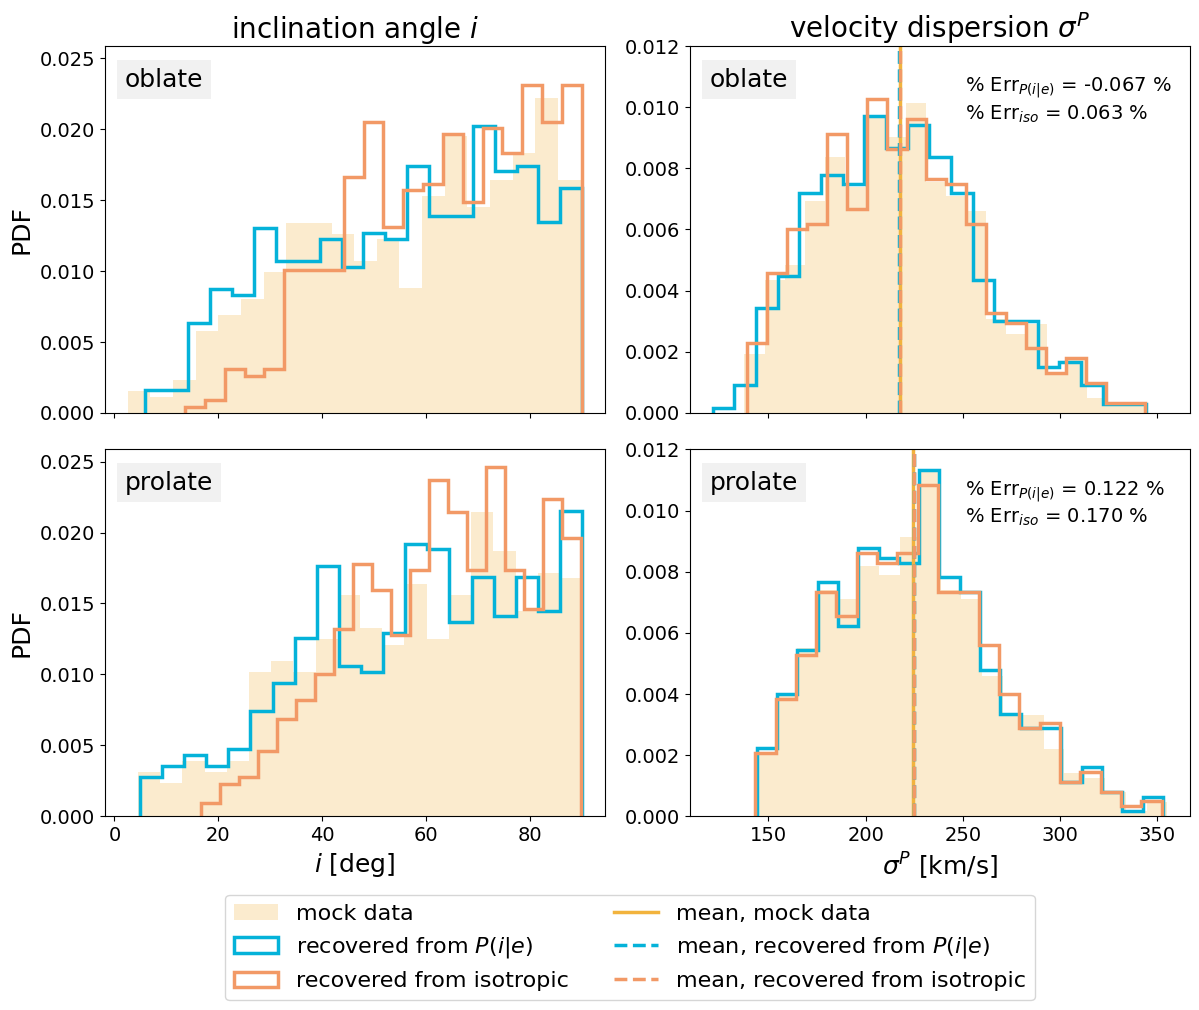

In [5]:
# Create a figure and a grid of subplots
fig = plt.figure(figsize = (14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace = 0.17)
axs = gs.subplots(sharex='col')
axs = axs.flatten()

color_pie = clist[0]
color_iso = clist[2]
color_data = clist[1]

lw_hist = 2.5

mock_all = [mock_oblate, mock_prolate]

for j, data in enumerate([data_oblate, data_prolate]):

    # plot the first column
    axs[2*j].hist(np.degrees(data[0]), bins=20, histtype='step', lw = lw_hist, density=True, color=color_pie)
    axs[2*j].hist(np.degrees(data[1]), bins=20, label = 'recovered from isotropic', histtype='step', lw = lw_hist, density=True, color=color_iso)
    axs[2*j].hist(mock_all[j][-1], bins = 20, label = 'mock data', alpha = 0.25, density=True, color=color_data)

    # set labels
    axs[2*j].label_outer()

    # plot the second column
    axs[2*j+1].hist(data[2], histtype='step', lw = lw_hist, label = r'recovered from $P(i\vert e)$', bins=20, density=True, color=color_pie)
    axs[2*j+1].hist(data[3], histtype='step', lw = lw_hist, label = 'recovered from isotropic', bins=20, density=True, color=color_iso)
    axs[2*j+1].hist(mock_all[j][2], alpha = 0.25, label = 'mock data', bins=20, density=True, color=color_data)

    # plot the mean values
    mean_mock_vel_disp = np.mean(mock_all[j][2])
    mean_recovered_pie = np.mean(data[2])
    mean_recovered_iso = np.mean(data[3])
    axs[2*j+1].axvline(mean_mock_vel_disp, marker = ' ', ls = '-', label = 'mean, mock data', color = color_data, lw=lw_hist)
    axs[2*j+1].axvline(mean_recovered_pie, marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)
    axs[2*j+1].axvline(mean_recovered_iso, marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)
    # annotate percent error
    axs[2*j+1].text(0.55, 0.8, s = r'% Err$_{P(i\vert e)}$'+' = {:.3f} %' .format(percent_err(mean_recovered_pie, mean_mock_vel_disp)) +'\n' + r'% Err$_{iso}$'+' = {:.3f} %' .format(percent_err(mean_recovered_iso, mean_mock_vel_disp)), fontsize=14, transform = axs[2*j+1].transAxes)

    
# set titles and labels
axs[0].set_title('inclination angle $i$',  fontsize=20)
axs[1].set_title(r'velocity dispersion $\sigma^P$',  fontsize=20)
axs[2].set_xlabel('$i$ [deg]')
axs[3].set_xlabel(r'$\sigma^P$ [km/s]')
axs[0].set_ylabel('PDF')
axs[2].set_ylabel('PDF')


axs[0].sharey(axs[2])
axs[3].set_ylim(0, 0.012)
axs[1].sharey(axs[3])

# adjust axis label size
for ax in axs:
    ax.xaxis.label.set(fontsize=18)
    ax.yaxis.label.set(fontsize=18)
    ax.tick_params(axis='both', labelsize = 14)

# annotate the with or without lensing selection
props = dict(boxstyle = 'square', facecolor = 'lightgray', alpha = 0.3, edgecolor = 'None')
for ax in axs[:2]:
    ax.text(0.04, 0.89, 'oblate', transform = ax.transAxes, fontsize = 18, bbox=props)
for ax in axs[2:]:
    ax.text(0.04, 0.89, 'prolate', transform = ax.transAxes, fontsize = 18, bbox=props)


# # Adjust layout to prevent overlapping titles
# plt.tight_layout()


# plot some dummy plots for legend making
dummy_labels = []
dummy_labels.append(patches.Patch(edgecolor='none', facecolor=color_data, label='mock data', alpha = 0.25))
dummy_labels.append(patches.Patch(edgecolor=color_pie, facecolor='none', label=r'recovered from $P(i\vert e)$', lw=lw_hist))
dummy_labels.append(patches.Patch(edgecolor=color_iso, facecolor='none', label='recovered from isotropic', lw=lw_hist))
dummy_labels.append(axs[1].plot([], [], marker = ' ', ls = '-', label = 'mean, mock data', color = color_data, lw=lw_hist)[0])
dummy_labels.append(axs[1].plot([], [], marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)[0])
dummy_labels.append(axs[1].plot([], [], marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)[0])

fig.legend(handles=dummy_labels, loc='lower center', bbox_to_anchor=(0.5, -0.085), ncol=2, fontsize=16)
# plt.savefig('./kin_recovery_axisym.pdf', bbox_inches='tight', dpi=300)

plt.show()